In [ ]:
# --- Scraper + Analysis Script ---
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
# --- Product Data ---
products = [
    ("Bananas", "https://www.target.com/p/organic-bananas-2lb-good-38-gather-8482/-/A-85759852#lnk=sametab"),
    ("Vegetable Oil", "https://www.target.com/p/vegetable-oil-good-gather/-/A-89467834?preselect=78376315#lnk=sametab"),
    ("Gum", "https://www.target.com/p/extra-spearmint-sugarfree-gum-15ct/-/A-13307857#lnk=sametab"),
    ("Toilet Paper", "https://www.target.com/p/cottonelle-ultra-comfort-toilet-paper/-/A-54605704?preselect=75665830#lnk=sametab"),
    ("AirPods", "https://www.target.com/p/apple-airpods-4/-/A-93606140?preselect=85978618#lnk=sametab"),
    ("Cotton Swabs", "https://www.target.com/p/q-tips-cotton-swabs-375ct/-/A-11223546#lnk=sametab"),
    ("Diapers", "https://www.target.com/p/pampers-swaddlers-active-baby-diapers-select-size-and-count/-/A-14783999?preselect=53461432#lnk=sametab"),
    ("T-Shirt", "https://www.target.com/p/women-s-linen-short-sleeve-t-shirt-universal-thread/-/A-93711326?preselect=92878440#lnk=sametab"),
    ("Eggs", "https://www.target.com/p/grade-a-large-eggs-12ct-good-38-gather-8482-packaging-may-vary/-/A-14713534#lnk=sametab"),
    ("Shampoo", "https://www.target.com/p/native-coconut-vanilla-moisturizing-shampoo/-/A-94666723?preselect=80120273#lnk=sametab"),
    ("Milk", "https://www.target.com/p/milk-good-gather/-/A-94602358?preselect=13276134#lnk=sametab")
]

#       rural, suburban, urban
zips = ['50702', '50009', '52404',
        '67401', '66062', '66111',
        '56601', '55066', '55403',
        '63010', '63033', '64114',
        '68073', '68123', '68116',
        '58563', '58701', '58103',
        '57701', '57401', '57110']

location = ['Waterloo, IA', 'Altoona, IA', 'Cedar Rapids, IA',
            'Salina, KS', 'Olathe, KS', 'Kansas City, KS',
            'Bemidji, MN', 'Red Wing, MN', 'Minneapolis, MN',
            'Arnold, MO', 'Florissant, MO', 'Kansas City, MO',
            'Yutan, NE', 'Bellevue, NE', 'Omaha, NE',
            'New Salem, ND', 'Minot, ND', 'Fargo, ND',
            'Rapid City, SD', 'Aberdeen, SD', 'Sioux Falls, SD']

city_town = ['Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban',
             'Rural', 'Suburban', 'Urban'] 


combined_data = []

# --- Setup Driver ---
def setup_driver():
    options = Options()
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument("--window-size=1920x1080")
    driver = webdriver.Firefox(options=options)
    driver.set_page_load_timeout(30)
    return driver

def close_modal(driver):
    try:
        WebDriverWait(driver, 5).until(
            EC.element_to_be_clickable((By.CLASS_NAME, "styles_overlay__3ZDC1"))
        )
        close_btn = driver.find_element(By.CLASS_NAME, "styles_overlay__3ZDC1")
        driver.execute_script("arguments[0].click();", close_btn)
        time.sleep(2)
    except:
        pass

# --- Scraping Loop ---
for product_name, url in products:
    print(f"📦 Scraping {product_name}...")
    driver = setup_driver()
    try:
        driver.get(url)
        time.sleep(5)
        close_modal(driver)

        price_element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, "//span[contains(@data-test, 'product-price')]"))
        )
        price = price_element.text
        #combined_data.append({"Product": product_name, "Zip Code": zips[0], "Price": price})
        print(f"✅ Zip Code: {zips} , Price: {price}")
        time.sleep(2)

        for zip_code in zips:
            try:
                time.sleep(2)
                
                edit_buttons = driver.find_elements(By.XPATH, '//*[@id="web-store-id-msg-btn"]/div/div[2]/span')
                time.sleep(3)
                if not edit_buttons:
                    print(f"❌ Could not find 'Edit your location' for zip {zip_code}")
                    continue
                edit_buttons[0].click()
                time.sleep(1)
                zip_input = driver.find_element(By.XPATH, '//*[@id="zip-or-city-state"]')
                zip_input.send_keys(Keys.COMMAND + "a")
                zip_input.send_keys(Keys.BACKSPACE)
                zip_input.send_keys(zip_code)
                time.sleep(1)
                
                print("Clicking the button to update zip")
                
                lookup = driver.find_element(By.XPATH, "/html/body/div[5]/div/div/div[2]/div[1]/div/div[1]/div[2]/button")
                lookup.click()
                time.sleep(3)
                
                first_available_store = driver.find_element(By.XPATH, "/html/body/div[5]/div/div/div[2]/div[2]/fieldset/div[1]/div/div[1]/label")
                first_available_store.click()
                time.sleep(1)
                
                shop_this_store = driver.find_element(By.XPATH, "/html/body/div[5]/div/div/div[3]/button")
                shop_this_store.click()
                time.sleep(3)
                
                price_element = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.XPATH, "//span[contains(@data-test, 'product-price')]"))
                )
                price = price_element.text
                combined_data.append({"Product": product_name, "Zip Code": zip_code, "Price": price})
                print(f"✅ Zip Code: {zip_code} , Price: {price}")

            except Exception as e:
                print(f"❌ Error processing zip {zip_code}: {e}")
    except Exception as e:
        print(f"❌ Error on main product for {product_name}: {e}")
    finally:
        driver.quit()

In [ ]:
# Updated! This cleans up the data and saves to to a csv, alongside printing the statistics.
# --- Data Cleanup ---
df = pd.DataFrame(combined_data)
display(df)
zip_map = dict(zip(zips, zip(location, city_town)))
df['Location'] = df['Zip Code'].map(lambda z: zip_map.get(z, ["", ""])[0])
df['Area Type'] = df['Zip Code'].map(lambda z: zip_map.get(z, ["", ""])[1])
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)

# --- Category Mapping ---
category_map = {
    "Bananas": "Food", "Vegetable Oil": "Food", "Gum": "Snack", "Toilet Paper": "Toiletries",
    "AirPods": "Electronics", "Cotton Swabs": "Toiletries", "Diapers": "Baby Care",
    "T-Shirt": "Clothing", "Eggs": "Food", "Shampoo": "Toiletries", "Milk": "Food"
}
df["Category"] = df["Product"].map(category_map)

df.to_csv("target_prices_combined.csv", index=False)
print("✅ All product data saved to target_prices_combined.csv")

# --- EDA + Visualization ---
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="Category", y="Price")
plt.title("Price Distribution by Product Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

pivot = df.pivot_table(index="Product", columns="Zip Code", values="Price", aggfunc='mean')
print("\n📊 Average Price by Product and ZIP Code:\n")
print(pivot)

print("\n📉 Product Price Variability (Standard Deviation):\n")
print(df.groupby("Product")["Price"].std())

# Linear Regression: Area Type → Price
df_reg = df.copy()
df_reg['Area Code'] = df_reg['Area Type'].map({'Suburban': 0, 'City': 1, 'Urban': 2})
df_reg = df_reg.dropna(subset=['Area Code'])

X = sm.add_constant(df_reg['Area Code'])
y = df_reg['Price']
model = sm.OLS(y, X).fit()
print("\n📈 Linear Regression Summary (Area Code → Price):\n")
print(model.summary())

# K-Means Clustering
pivot_df = df.pivot_table(index="Zip Code", columns="Product", values="Price")
pivot_df = pivot_df.dropna()
if pivot_df.shape[0] >= 2:
    scaler = StandardScaler()
    scaled = scaler.fit_transform(pivot_df)
    kmeans = KMeans(n_clusters=2, random_state=42)
    pivot_df['Cluster'] = kmeans.fit_predict(scaled)
    print("\n ZIP Code Clusters:\n")
    print(pivot_df['Cluster'])
else:
    print("\n Not enough ZIP Codes with full product prices to perform clustering.")

# Group Means
print("\n🏙️ Average Price by Area Type:\n")
print(df.groupby(['Area Type'])['Price'].mean())

print("\n📊 Average Price by Category and Area Type:\n")
print(df.groupby(['Category', 'Area Type'])['Price'].mean().unstack())

# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Price Variation of Products by ZIP Code")
plt.tight_layout()
plt.show()


# In[ ]:

In [ ]:
# This version of the code just displays the statistics, importing from a csv so we don't have to re-run the scrapes.
# --- Data Cleanup ---
df = pd.read_csv("target_prices_combined_mountain.csv")
display(df)

# --- Category Mapping ---
category_map = {
    "Bananas": "Food", "Vegetable Oil": "Food", "Gum": "Snack", "Toilet Paper": "Toiletries",
    "AirPods": "Electronics", "Cotton Swabs": "Toiletries", "Diapers": "Baby Care",
    "T-Shirt": "Clothing", "Eggs": "Food", "Shampoo": "Toiletries", "Milk": "Food"
}
df["Category"] = df["Product"].map(category_map)


# --- EDA + Visualization ---
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="Category", y="Price")
plt.title("Price Distribution by Product Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

pivot = df.pivot_table(index="Product", columns="Zip Code", values="Price", aggfunc='mean')
print("\n📊 Average Price by Product and ZIP Code:\n")
print(pivot)

print("\n📉 Product Price Variability (Standard Deviation):\n")
print(df.groupby("Product")["Price"].std())

# Linear Regression: Area Type → Price
df_reg = df.copy()
df_reg['Area Code'] = df_reg['Area Type'].map({'Suburban': 0, 'City': 1, 'Urban': 2})
df_reg = df_reg.dropna(subset=['Area Code'])

X = sm.add_constant(df_reg['Area Code'])
y = df_reg['Price']
model = sm.OLS(y, X).fit()
print("\n📈 Linear Regression Summary (Area Code → Price):\n")
print(model.summary())

# K-Means Clustering
pivot_df = df.pivot_table(index="Zip Code", columns="Product", values="Price")
pivot_df = pivot_df.dropna()
if pivot_df.shape[0] >= 2:
    scaler = StandardScaler()
    scaled = scaler.fit_transform(pivot_df)
    kmeans = KMeans(n_clusters=2, random_state=42)
    pivot_df['Cluster'] = kmeans.fit_predict(scaled)
    print("\n ZIP Code Clusters:\n")
    print(pivot_df['Cluster'])
else:
    print("\n Not enough ZIP Codes with full product prices to perform clustering.")

# Group Means
print("\n🏙️ Average Price by Area Type:\n")
print(df.groupby(['Area Type'])['Price'].mean())

print("\n📊 Average Price by Category and Area Type:\n")
print(df.groupby(['Category', 'Area Type'])['Price'].mean().unstack())

# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Price Variation of Products by ZIP Code")
plt.tight_layout()
plt.show()

In [1]:
# get yer imports here

import pandas as pd
import math

# This data is from this website: https://gist.github.com/pramodpendyala/e5688b6a63d2983eac804bbaa1fd7cc0

address_data = pd.read_csv('2023_Gaz_zcta_national.txt', sep="\t", header=None)
address_data.columns = address_data.iloc[0]
address_data = address_data.drop(0)
# Why is the column name like this. Who is responsible. I just want to talk.
address_data.rename(columns={'INTPTLONG                                                                                                                                  ':'INTPTLONG'}, inplace=True)

address_data['INTPTLAT'] = address_data['INTPTLAT'].apply(lambda x: float(x))
address_data['INTPTLONG'] = address_data['INTPTLONG'].apply(lambda x: float(x))

address_data = address_data.drop(["ALAND", "AWATER", "ALAND_SQMI", "AWATER_SQMI"], axis=1)

address_data


# This data is found from this website: https://warehouse.ninja/target-distribution-center-locations/
# I inputted it manually, unfortunately.

warehouse_data = [[34.6449932755897,-86.8473292167007],
                  [33.44847758394,-112.216516477379],
                  [35.4443517679111,-119.184883986437],
                  [34.1129032695058,-117.481059984653],
                  [34.1556649469121,-117.430952966951],
                  [33.8829312577458,-117.266820757673],
                  [38.6830449523077,-121.721678642205],
                  [34.1342886776624,-117.416355370662],
                  [38.2782732480079,-104.467643668806],
                  [39.8102931481305,-104.986460657673],
                  [30.2323049532679,-82.6359163730191],
                  [31.7765737205048,-81.3526562288365],
                  [31.7776443503854,-81.3539269910744],
                  [31.4215451402305,-83.5182432359064],
                  [32.1739955290448,-81.1755252030619],
                  [21.4792398115305,-158.016842329534],
                  [41.9176226241567,-88.7369320728707],
                  [41.8303900458523,-87.7238539644176],
                  [41.8002418685309,-87.7811810344034],
                  [41.4744170168815,-88.1627609565227],
                  [41.9218023710286,-87.9598046121732],
                  [39.7475498809776,-86.2948367214139],
                  [42.4760732243742,-92.468984016849],
                  [38.9662278505392,-95.6943807344034],
                  [38.8653486027871,-76.7299089768994],
                  [44.9647972364202,-85.2029499259567],
                  [45.0979857630195,-93.2491908864199],
                  [44.9933873277923,-93.2149055171079],
                  [44.9452591409893,-92.9121249623863],
                  [40.5251569148739,-74.2592140725181],
                  [40.089765436428,-74.8200981032102],
                  [39.7817015818632,-75.3450861543144],
                  [43.178721716844,-73.7161892865095],
                  [42.9386799514717,-74.2384685711634],
                  [35.6225966445846,-81.3098264595263],
                  [39.9520393926857,-83.3482983306921],
                  [39.9471432044632,-83.3518352558173],
                  [44.5794790802794,-123.115068328716],
                  [40.1989563009857,-76.8052668801052],
                  [39.8890231958012,-77.6729397],
                  [34.1794119094042,-80.6818378840045],
                  [32.4347483116907,-97.0555079725181],
                  [34.5570298314302,-97.1446958584889],
                  [32.8696311238109,-95.6389149051154],
                  [32.8807284643133,-96.901032357673],
                  [29.9461573473188,-95.5288642134904],
                  [38.0306730381623,-78.998851715346],
                  [36.7076274133422,-76.6651214220913],
                  [47.0821524927726,-122.771626284653],
                  [43.080037381646,-88.4760084558174],
                  [42.4825228934735,-92.4709803136662]]
sample_data = [['17013', 4.69],
               ['22209', 2.49],
               ['19103', 5.29],
               ['07036', 4.19],
               ['21224', 3.89],
               ['12205', 2.69],
               ['10025', 4.59],
               ['16509', 4.89]]

sample_data = pd.DataFrame(sample_data)
sample_data.columns = ["Zip", "Price"]

sample_data = sample_data.merge(right=address_data, left_on="Zip", right_on="GEOID")
sample_data = sample_data.drop("GEOID", axis=1)

def closest_to_distro_center(row):
    distances = []
    
    """
    for coordinate in warehouse_data:
        distance_form_x = pow((row["INTPTLAT"] - coordinate[0]), 2)
        distance_form_y = pow((row["INTPTLONG"] - coordinate[1]), 2)
        distances.append(math.sqrt(distance_form_x + distance_form_y))
    """
    
    for coordinate in warehouse_data:
        # I'll be honest, I have no idea how this works. I don't know most of my trig knowledge anymore, and I am trusting this stackoverflow person with my life.
        # https://stackoverflow.com/questions/365826/calculate-distance-between-2-gps-coordinates
        earth_radius = 3959  # This is earth's radius in miles. I can switch this to fm by changing the number to 6371
        
        distance_lat = math.radians(row["INTPTLAT"] - coordinate[0])
        distance_lon = math.radians(row["INTPTLONG"] - coordinate[1])
        
        lat1 = math.radians(row["INTPTLAT"])
        lat2 = math.radians(coordinate[0])
        
        a = pow(math.sin(distance_lat / 2), 2) + (pow(math.sin(distance_lon / 2), 2) * math.cos(lat1) * math.cos(lat2))
        
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distances.append(earth_radius * c)
        
    
    return min(distances)


sample_data["Closest Distro Center"] = sample_data.apply(closest_to_distro_center, axis=1)

sample_data




FileNotFoundError: [Errno 2] No such file or directory: '2023_Gaz_zcta_national.txt'

In [ ]:
# Getting and cleaning the data.

file_names = ["target_prices_combined_east_south_central",
              "target_prices_combined_mountain",
              "target_prices_combined_pacific",
              "target_prices_combined_south_atlantic",
              "target_prices_combined_west_north_central",
              "target_prices_combined_west_south_central",
              "target_prices_NE",
              "target_prices_NEC_full",
              "target_pricing_MA"]

for file in file_names:
    globals()[file] = pd.read_csv("scraped data to combine into full dataframe/" + file + ".csv")

    
# This is the section where I clean up some of the data so I can mash it all together in a sec.

# Starting with defining some functions that I'll use to clean the data, of course.

# Some zips aren't 5 numbers long.
def zip_extender_and_stringifier(code):
    if len(str(int(code))) != 5:
        return "0" + str(int(code))
    return str(int(code))

def price_floater(price):
    # I did not need to make this one line. I probably should not have made this one line. But I did anyways, because it made me feel awesome.
    return float(price.split('$')[-1].split('.')[0]) + float(price.split('$')[-1].split('.')[1])/100

def rent_floater(price):
    # This is just price floater, but for thousands instead of tens with decimals.
    if "," in price:
        return float(price.split('$')[-1].split(',')[0])*1000 + float(price.split('$')[-1].split(',')[1])
    else:
        return float(price.split('$')[-1])

def airpod_capitalizer(product):
    if product == 'Airpods':
        return 'AirPods'
    return product

def classification_fixer(classification):
    return classification.title().split(' ')[0]


target_prices_NE = target_prices_NE.drop("Unnamed: 5", axis=1)  # Drops mysterious sixth column.
target_prices_NE = target_prices_NE.dropna()  # Removes null values from data.
target_prices_NE["Zip Code"] = target_prices_NE["Zip Code"].apply(zip_extender_and_stringifier)  # Fixes zips being registered as floats
target_prices_NE["Price"] = target_prices_NE["Price"].apply(price_floater)  # Turns prices into floats
target_prices_NE["Classification"] = target_prices_NE["Classification"].apply(classification_fixer)  # Fixes capitalization on classifications
target_prices_NE = target_prices_NE.rename(columns={'Classification': 'Area Type'})  # ...only to immediately rename the column.

# Doing the same with the other two. I tried to do this as a loop, but pandas didn't like that very much.
target_prices_NEC_full = target_prices_NEC_full.dropna()
target_prices_NEC_full["Zip Code"] = target_prices_NEC_full["Zip Code"].apply(zip_extender_and_stringifier)
target_prices_NEC_full["Price"] = target_prices_NEC_full["Price"].apply(price_floater)
target_prices_NEC_full["Classification"] = target_prices_NEC_full["Classification"].apply(classification_fixer)
target_prices_NEC_full["Product"] = target_prices_NEC_full["Product"].apply(airpod_capitalizer) # This one changes Airpods to AirPods, to match the others' capitalization of the word. 
target_prices_NEC_full = target_prices_NEC_full.rename(columns={'Classification': 'Area Type'})

target_pricing_MA = target_pricing_MA.dropna()
target_pricing_MA["Zip Code"] = target_pricing_MA["Zip Code"].apply(zip_extender_and_stringifier)
target_pricing_MA["Price"] = target_pricing_MA["Price"].apply(price_floater)
target_pricing_MA["Classification"] = target_pricing_MA["Classification"].apply(classification_fixer)
target_pricing_MA = target_pricing_MA.rename(columns={'Classification': 'Area Type'})


# I messed up some of my data collection, so I'm fixing that manually(ish) for the files I know are affected.

target_prices_combined_mountain = target_prices_combined_mountain.drop(range(0,275,25))
target_prices_combined_mountain = target_prices_combined_mountain.drop(range(10,275,25))  # I accidentally duplicated 59718. I'm gonna have to re-scrape mountain later. fml.

target_prices_combined_pacific = target_prices_combined_pacific.drop(range(0,165,15))

target_prices_combined_west_south_central = target_prices_combined_west_south_central.drop(range(0,143,13))


# I have no idea why my code is breaking. i'm just gonna try this out of desperation.
target_prices_combined_east_south_central["Zip Code"] = target_prices_combined_east_south_central["Zip Code"].apply(zip_extender_and_stringifier)
target_prices_combined_mountain["Zip Code"] = target_prices_combined_mountain["Zip Code"].apply(zip_extender_and_stringifier)
target_prices_combined_pacific["Zip Code"] = target_prices_combined_pacific["Zip Code"].apply(zip_extender_and_stringifier)
target_prices_combined_south_atlantic["Zip Code"] = target_prices_combined_south_atlantic["Zip Code"].apply(zip_extender_and_stringifier)
target_prices_combined_west_north_central["Zip Code"] = target_prices_combined_west_north_central["Zip Code"].apply(zip_extender_and_stringifier)
target_prices_combined_west_south_central["Zip Code"] = target_prices_combined_west_south_central["Zip Code"].apply(zip_extender_and_stringifier)
# Oh hey, this actually fixed it! Well I'm keeping these here because they make all the column additions good.



# And now I get to pivot and combine them. This part's really satisfying.

files_to_concat = []

for file in file_names:
    df = globals()[file]
    
    print("pivoting", file)
    product_prices = df.pivot(index='Zip Code', columns='Product', values='Price')
    
    print("location+class for", file)
    location_and_class = df.drop_duplicates("Zip Code")
    location_and_class = location_and_class.drop(['Product', 'Price'], axis=1)
    try:
        location_and_class = location_and_class.drop('Category', axis=1)
    except:
        pass
    location_and_class = location_and_class.set_index('Zip Code')

    print("combining", file)
    out4 = pd.concat([product_prices, location_and_class], axis=1)
    #display(out4)
    print("done!")
    
    globals()["pivot_" + file] = out4  # I don't know if I'll need this? but I'll keep it in, just in case people want individual files.
    files_to_concat.append(globals()["pivot_" + file])  # This adds it to the list of frames to concat together.

full_data = pd.concat(files_to_concat)
display(full_data)



# This data is found from this website: https://warehouse.ninja/target-distribution-center-locations/
# I inputted it manually, unfortunately.

warehouse_data = [[34.6449932755897,-86.8473292167007],
                  [33.44847758394,-112.216516477379],
                  [35.4443517679111,-119.184883986437],
                  [34.1129032695058,-117.481059984653],
                  [34.1556649469121,-117.430952966951],
                  [33.8829312577458,-117.266820757673],
                  [38.6830449523077,-121.721678642205],
                  [34.1342886776624,-117.416355370662],
                  [38.2782732480079,-104.467643668806],
                  [39.8102931481305,-104.986460657673],
                  [30.2323049532679,-82.6359163730191],
                  [31.7765737205048,-81.3526562288365],
                  [31.7776443503854,-81.3539269910744],
                  [31.4215451402305,-83.5182432359064],
                  [32.1739955290448,-81.1755252030619],
                  [21.4792398115305,-158.016842329534],
                  [41.9176226241567,-88.7369320728707],
                  [41.8303900458523,-87.7238539644176],
                  [41.8002418685309,-87.7811810344034],
                  [41.4744170168815,-88.1627609565227],
                  [41.9218023710286,-87.9598046121732],
                  [39.7475498809776,-86.2948367214139],
                  [42.4760732243742,-92.468984016849],
                  [38.9662278505392,-95.6943807344034],
                  [38.8653486027871,-76.7299089768994],
                  [44.9647972364202,-85.2029499259567],
                  [45.0979857630195,-93.2491908864199],
                  [44.9933873277923,-93.2149055171079],
                  [44.9452591409893,-92.9121249623863],
                  [40.5251569148739,-74.2592140725181],
                  [40.089765436428,-74.8200981032102],
                  [39.7817015818632,-75.3450861543144],
                  [43.178721716844,-73.7161892865095],
                  [42.9386799514717,-74.2384685711634],
                  [35.6225966445846,-81.3098264595263],
                  [39.9520393926857,-83.3482983306921],
                  [39.9471432044632,-83.3518352558173],
                  [44.5794790802794,-123.115068328716],
                  [40.1989563009857,-76.8052668801052],
                  [39.8890231958012,-77.6729397],
                  [34.1794119094042,-80.6818378840045],
                  [32.4347483116907,-97.0555079725181],
                  [34.5570298314302,-97.1446958584889],
                  [32.8696311238109,-95.6389149051154],
                  [32.8807284643133,-96.901032357673],
                  [29.9461573473188,-95.5288642134904],
                  [38.0306730381623,-78.998851715346],
                  [36.7076274133422,-76.6651214220913],
                  [47.0821524927726,-122.771626284653],
                  [43.080037381646,-88.4760084558174],
                  [42.4825228934735,-92.4709803136662]]
# This data is from this website: https://gist.github.com/pramodpendyala/e5688b6a63d2983eac804bbaa1fd7cc0

address_data = pd.read_csv('2023_Gaz_zcta_national.txt', sep="\t", header=None)
address_data.columns = address_data.iloc[0]
address_data = address_data.drop(0)
# Why is the column name like this. Who is responsible. I just want to talk.
address_data.rename(columns={'INTPTLONG                                                                                                                                  ':'INTPTLONG'}, inplace=True)

address_data['INTPTLAT'] = address_data['INTPTLAT'].apply(lambda x: float(x))
address_data['INTPTLONG'] = address_data['INTPTLONG'].apply(lambda x: float(x))

address_data = address_data.drop(["ALAND", "AWATER", "ALAND_SQMI", "AWATER_SQMI"], axis=1)

address_data = address_data.rename(columns={'GEOID': 'Zip Code'})
address_data = address_data.set_index('Zip Code')



full_data = full_data.join(address_data, how='left')

def closest_to_distro_center(row):
    distances = []
    
    
    for coordinate in warehouse_data:
        # I'll be honest, I have no idea how this works. I don't know most of my trig knowledge anymore, and I am trusting this stackoverflow person with my life.
        # https://stackoverflow.com/questions/365826/calculate-distance-between-2-gps-coordinates
        earth_radius = 3959  # This is earth's radius in miles. I can switch this to fm by changing the number to 6371
        
        distance_lat = math.radians(row["INTPTLAT"] - coordinate[0])
        distance_lon = math.radians(row["INTPTLONG"] - coordinate[1])
        
        lat1 = math.radians(row["INTPTLAT"])
        lat2 = math.radians(coordinate[0])
        
        a = pow(math.sin(distance_lat / 2), 2) + (pow(math.sin(distance_lon / 2), 2) * math.cos(lat1) * math.cos(lat2))
        
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distances.append(earth_radius * c)
        
    
    return min(distances)


full_data["Closest Distro Center"] = full_data.apply(closest_to_distro_center, axis=1)

full_data = full_data.drop(["INTPTLAT", "INTPTLONG"], axis=1)
display(full_data)


# Ok now to add the rent data to the columns.

rent = pd.read_csv("scraped data to combine into full dataframe/df_rent.csv")
#display(rent)
rent = rent.drop(["Unnamed: 9", "Unnamed: 10", "Unnamed: 11", "Unnamed: 12", "Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16", "Unnamed: 17", "Unnamed: 18", "Unnamed: 19"], axis=1)
#display(rent)
rent = rent.dropna()
rent = rent.rename(columns={'ZIP': 'Zip Code'})
rent["Zip Code"] = rent["Zip Code"].apply(zip_extender_and_stringifier)  # Fixes zips being registered as floats
rent = rent.set_index('Zip Code')
#display(rent)
rent["Studio"] = rent["Studio"].apply(rent_floater)
rent["1BR"] = rent["1BR"].apply(rent_floater)
rent["2BR"] = rent["2BR"].apply(rent_floater)
rent["3BR"] = rent["3BR"].apply(rent_floater)
rent["4BR"] = rent["4BR"].apply(rent_floater)

full_data = full_data.join(rent, how='left')



# And I'll also make sure to add income.

income = pd.read_excel("scraped data to combine into full dataframe/Med_income.xlsx")
income = income.drop("Unnamed: 3", axis=1)
income = income.rename(columns={'ZIP': 'Zip Code'})
income["Zip Code"] = income["Zip Code"].apply(zip_extender_and_stringifier)  # Fixes zips being registered as floats
income = income.set_index('Zip Code')


full_data = full_data.join(income, how='left')

full_data = full_data.drop_duplicates()

display(full_data)

# When importing the data as a CSV, make sure to turn the zip code back into an index so it doesn't get in the way.
# I have an example of doing this in the data modeling file, right at the top in the clustering section.
full_data.to_csv("full_data.csv")

,AirPods,Bananas,Cotton Swabs,Diapers,Eggs,Gum,Milk,Shampoo,T-Shirt,Toilet Paper,Vegetable Oil,Closest Distro Center,Unemployment Rate,Median Income,Population,Rent
Zip Code,,,,,,,,,,,,,,,,
01040,179.99,1.99,3.39,44.99,4.99,1.79,4.19,9.99,9.6,12.99,9.39,86.245840,3.9,51892.0,38238.0,1521.0
02114,179.99,1.99,3.39,44.99,5.49,1.69,4.19,9.99,9.6,12.99,9.39,145.695293,3.0,135057.0,14469.0,2804.4
02122,179.99,1.99,3.39,44.99,5.49,1.79,4.19,9.99,9.6,12.99,9.39,148.321890,3.4,82945.0,24385.0,2804.4
02865,179.99,1.99,3.39,44.99,4.99,1.69,3.89,9.99,9.6,12.99,9.39,144.662267,3.7,117042.0,17902.0,1694.0
02886,179.99,1.99,3.39,44.99,4.99,1.79,3.89,9.99,9.6,12.99,9.39,153.968645,2.8,91037.0,29373.0,1694.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98614,179.99,1.99,3.39,44.99,4.49,1.79,3.69,9.99,9.6,12.99,9.39,77.515806,5.8,83560.0,16034.0,1828.6
98626,179.99,1.99,3.39,44.99,4.49,1.79,3.69,9.99,9.6,12.99,9.39,62.878349,7.1,70058.0,26291.0,1575.6
98901,179.99,1.99,3.39,44.99,1.99,1.79,3.59,9.99,9.6,12.99,9.39,118.479044,6.7,128143.0,16237.0,1456.2


Cluster labels: [1 2 3 0 0 0 0 2 2 3 1 3 0 0 3 3 1 2 3 2 3 1 1 1 1 0 0 0 1 3 3 0 0 2 0 3 3
 3 3 3 1 2 3 1 1 0 0 0 3 3 1 1 0 1 0 3 2 3 3 3 1 0 1 1 1 3 0 1 1 1 2 1 1 0
 3 1 3 1 3 3 3 1 3 1 1 1 3 1 0 1 0 0 1 1 1 3 0 3 1 0 0 0 1 1 3 1 1 3 0 1 1
 1 2 0 0 2 0 3 0 3 0 1 0 1 0 0 0 0 0 1 1 3 1 0 3 0 1 0 2 0 0 1 1 3 3 3 2 0
 0]
Centroids: [[1.79990000e+02 2.08782609e+00 3.44000000e+00 4.49900000e+01
  4.84217391e+00 1.77913043e+00 3.49000000e+00 1.00030435e+01
  9.60000000e+00 1.31247826e+01 9.45956522e+00 1.97713808e+02
  3.99130435e+00 1.02600761e+05 3.22655000e+04 1.76806522e+03]
 [1.79990000e+02 1.99400000e+00 3.40200000e+00 4.49900000e+01
  4.87800000e+00 1.76000000e+00 3.54600000e+00 1.00020000e+01
  9.60000000e+00 1.30100000e+01 9.41000000e+00 1.55871583e+02
  4.61800000e+00 6.73951400e+04 4.33794600e+04 1.42294800e+03]
 [1.79990000e+02 2.19769231e+00 3.40538462e+00 4.49900000e+01
  4.53615385e+00 1.73615385e+00 3.65153846e+00 9.99000000e+00
  9.60000000e+00 1.30669231e+01 9.39000000e+00 

/Users/nishthasharma/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,AirPods,Bananas,Cotton Swabs,Diapers,Eggs,Gum,Milk,Shampoo,T-Shirt,Toilet Paper,...,Studio,1BR,2BR,3BR,4BR,Division,Region,Median Income,Population,Cluster
Zip Code,,,,,,,,,,,,,,,,,,,,,
02865,179.99,1.99,3.39,44.99,4.99,1.69,3.89,9.99,9.6,12.99,...,1233.0,1319.0,1614.0,1945.0,2359.0,New England,Northeast,117042.0,17902.0,0
02886,NaN,1.99,NaN,44.99,4.99,1.79,NaN,NaN,9.6,NaN,...,1233.0,1319.0,1614.0,1945.0,2359.0,New England,Northeast,91037.0,29373.0,0
02917,179.99,1.99,3.39,44.99,5.99,1.69,3.89,9.99,9.6,12.99,...,1233.0,1319.0,1614.0,1945.0,2359.0,New England,Northeast,106924.0,16036.0,0
03063,179.99,1.99,3.39,44.99,4.99,1.69,3.49,9.99,9.6,12.99,...,1184.0,1192.0,1564.0,1917.0,2405.0,New England,Northeast,106924.0,16036.0,0
05403,179.99,1.99,3.39,44.99,4.99,1.69,3.49,9.99,NaN,12.99,...,1380.0,1476.0,1936.0,2491.0,2567.0,New England,Northeast,97041.0,20166.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87402,179.99,1.99,3.39,44.99,4.99,1.79,3.39,9.99,9.6,12.99,...,841.0,855.0,1034.0,1449.0,1571.0,Mountain,West,76992.0,11646.0,3
89705,179.99,1.99,3.39,44.99,1.49,1.79,4.69,9.99,9.6,12.99,...,1004.0,1199.0,1464.0,2051.0,2458.0,Mountain,West,78269.0,5266.0,3
98233,179.99,1.99,3.39,44.99,1.99,1.79,3.49,9.99,9.6,12.99,...,1166.0,1300.0,1701.0,2384.0,2592.0,Pacific,West,83560.0,16034.0,3


---Model for AirPods---
Mean Squared Error: 3.2311742677852644e-27
Coefficients for AirPods:
	Bananas: 3.0383063048349176e-26
	Cotton Swabs: -1.2210486830396314e-25
	Diapers: 7.611836372565911e-37
	Eggs: -5.599572838321809e-28
	Gum: 7.246494962983605e-26
	Milk: -2.5048044109801948e-27
	Shampoo: 1.3395225181840445e-26
	T-Shirt: 6.313690360862117e-41
	Toilet Paper: -3.79744848994229e-26
	Vegetable Oil: 6.323840704712484e-26
	Closest Distro Center: 4.8793267327679203e-29
	Unemployment Rate: 6.520216386618603e-28
	Median Income: -5.1529310745109074e-33
	Population: -5.216017881563656e-32
	Rent: 3.528387356233264e-30

Leading coeff for AirPods is Cotton Swabs


FileNotFoundError: [Errno 2] No such file or directory: 'saved_figures/scatterplot/AirPods vs Cotton Swabs.png'

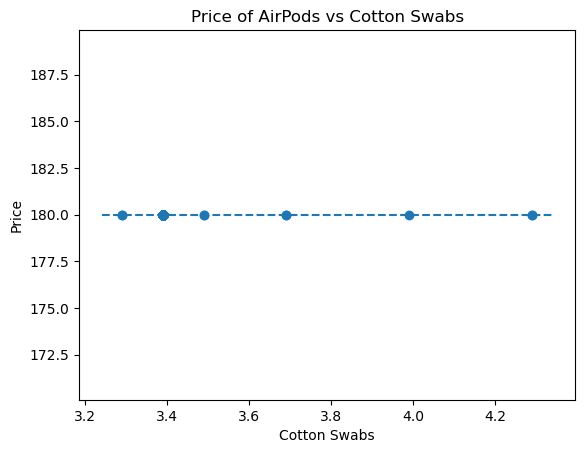

In [4]:
# imports :3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Bringing in the data.
# I do this for both linear regression and clustering, so I feel like I should have it happen out here.

data = pd.read_csv("full_data.csv")

# Sure is annoying having to redefine this. Oh, well!
def zip_extender_and_stringifier(code):
    if len(str(int(code))) != 5:
        return "0" + str(int(code))
    return str(int(code))
data["Zip Code"] = data["Zip Code"].apply(zip_extender_and_stringifier)

data = data.set_index('Zip Code')

#display(data)
# I can't have any categorical variables for clustering, unfortunately.
data_clustering_version = data.copy()
data_clustering_version = data_clustering_version.drop(["Location", "Area Type", "Division", "Region"], axis=1)
data_clustering_version = data_clustering_version.fillna(method='ffill')

# Averaging the rent to try and get more conclusive results.
data_averaging_for_rent = data_clustering_version.drop(["AirPods", "Bananas", "Cotton Swabs", "Diapers", "Eggs", "Gum", "Milk", "Shampoo", "T-Shirt", "Toilet Paper", "Vegetable Oil", "Closest Distro Center", "Unemployment Rate", "Median Income", "Population"], axis=1)
data_averaging_for_rent = data_averaging_for_rent.mean(axis=1)

data_clustering_version["Rent"] = data_averaging_for_rent
data_clustering_version = data_clustering_version.drop(["Studio", "1BR", "2BR", "3BR", "4BR"], axis=1)

display(data_clustering_version)



# Specify the number of clusters
k = 4

# Create k-means object and fit the data
kmeans = KMeans(n_clusters=k)
kmeans.fit(data_clustering_version)

# Get cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Print results
print("Cluster labels:", labels)
print("Centroids:", centroids)

data_clustering_results = data.copy()

data_clustering_results["Cluster"] = labels

data_clustering_results = data_clustering_results.sort_values(["Cluster", "Zip Code"])


# When importing the data as a CSV, make sure to turn the zip code back into an index so it doesn't get in the way.
# Uncomment the line below if you'd prefer to export to a csv instead of working in this file.
# data_clustering_results.to_csv("clustered_data.csv")

display(data_clustering_results)


# Linear Regression! I think I got everything I need for this? I kinda wish it had more visualization to it, but I couldn't really do that.

data_modeling_version = data.drop(["Location", "Area Type", "Division", "Region"], axis=1)
data_modeling_version = data_modeling_version.fillna(method='ffill')

# Averaging the rent to try and get more conclusive results.
data_averaging_for_rent = data_modeling_version.drop(["AirPods", "Bananas", "Cotton Swabs", "Diapers", "Eggs", "Gum", "Milk", "Shampoo", "T-Shirt", "Toilet Paper", "Vegetable Oil", "Closest Distro Center", "Unemployment Rate", "Median Income", "Population"], axis=1)
data_averaging_for_rent = data_averaging_for_rent.mean(axis=1)

data_modeling_version["Rent"] = data_averaging_for_rent
data_modeling_version = data_modeling_version.drop(["Studio", "1BR", "2BR", "3BR", "4BR"], axis=1)





# I'll need this for later.
coeff_labels = ['Closest Distro Center', 'Unemployment Rate', 'Median Income', 'Population', 'Rent']

product_list = ['AirPods', 'Bananas', 'Cotton Swabs', 'Diapers', 'Eggs', 'Gum', 'Milk', 'Shampoo', 'T-Shirt', 'Toilet Paper', 'Vegetable Oil']

for product in product_list:
    # Separate features (X) and target variable (y)
    #X = data_modeling_version.drop(product_list, axis=1)
    X = data_modeling_version.drop(product, axis=1)
    y = data_modeling_version[product]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Create Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    print("---Model for " + product + "---")
    
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

    
    
    # grab the coefficients! I'm gonna print them out all neatly.
    coefficients = model.coef_
    
    coeff_labels = ['Closest Distro Center', 'Unemployment Rate', 'Median Income', 'Population', 'Rent']
    modified_product_list = ['AirPods', 'Bananas', 'Cotton Swabs', 'Diapers', 'Eggs', 'Gum', 'Milk', 'Shampoo', 'T-Shirt', 'Toilet Paper', 'Vegetable Oil']
    modified_product_list.remove(product)
    
    coeff_labels = modified_product_list + coeff_labels
    
    
    
    big_ol_print = "Coefficients for " + product + ":\n"
    for x in range(0, len(coefficients)):
        big_ol_print += "\t" + coeff_labels[x] + ": " + str(coefficients[x]) + "\n"
        
    print(big_ol_print)
    
    
    leading_coefficient = 0
    leading_coeff_label = ""
    for x in range(0, len(coefficients)):
        if abs(coefficients[x]) > leading_coefficient:
            leading_coefficient = abs(coefficients[x])
            leading_coeff_label = coeff_labels[x]
    print("Leading coeff for", product, "is", leading_coeff_label)
    
    plt.scatter(x=data_modeling_version[leading_coeff_label], y=data_modeling_version[product], )
    
    
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = model.intercept_ + leading_coefficient * x_vals  # I could also use np.sum(model.coef_) instead of leading_coefficient, but that feels dishonest.
    plt.plot(x_vals, y_vals, '--')
    
    
    plt.title("Price of " + product + " vs " + leading_coeff_label)
    plt.xlabel(leading_coeff_label)
    plt.ylabel("Price")
    
    
    plt.savefig("saved_figures/scatterplot/" + product + " vs " + leading_coeff_label + ".png", dpi=300, bbox_inches='tight')
    
    plt.show()


print("done!")



done!
data_for_mapping = data.copy()


address_data = pd.read_csv('2023_Gaz_zcta_national.txt', sep="\t", header=None)
address_data.columns = address_data.iloc[0]
address_data = address_data.drop(0)
# Why is the column name like this. Who is responsible. I just want to talk.
address_data.rename(columns={'INTPTLONG                                                                                                                                  ':'INTPTLONG'}, inplace=True)

address_data['INTPTLAT'] = address_data['INTPTLAT'].apply(lambda x: float(x))
address_data['INTPTLONG'] = address_data['INTPTLONG'].apply(lambda x: float(x))

address_data = address_data.drop(["ALAND", "AWATER", "ALAND_SQMI", "AWATER_SQMI"], axis=1)

address_data = address_data.rename(columns={'GEOID': 'Zip Code'})
address_data = address_data.set_index('Zip Code', drop=False)


state_map = {
    '06241': 'CT',
    '06042': 'CT',
    '06901': 'CT',
    
    '04952': 'ME', 
    '04086': 'ME', 
    '04401': 'ME',
    
    '01040': 'MA', 
    '02122': 'MA', 
    '02114': 'MA', 
    
    '03840': 'NH', 
    '03110': 'NH', 
    '03063': 'NH', 
    
    '02917': 'RI', 
    '02886': 'RI', 
    '02865': 'RI', 
    
    '05403': 'VT', 

    '08865': 'NJ', 
    '07047': 'NJ', 
    '07310': 'NJ', 
    
    '14020': 'NY', 
    '14850': 'NY', 
    '11217': 'NY',
    
    '16601': 'PA', 
    '17013': 'PA', 
    '19103': 'PA',
    
    '61401': 'IL', 
    '60014': 'IL', 
    '60610': 'IL',
    
    '47401': 'IN', 
    '46383': 'IN', 
    '46237': 'IN',
    
    '49855': 'MI', 
    '48374': 'MI', 
    '48507': 'MI',
    
    '44870': 'OH', 
    '45236': 'OH', 
    '45249': 'OH', 
    
    '54235': 'WI', 
    '53085': 'WI', 
    '53207': 'WI'

}

def get_state(zipcode):
    if zipcode == '79707':
        return 'TX'  # It's stupid that i had to do this, but it works LMAO
    elif zipcode not in state_map:
        #print(zipcode, "not in the map: " + data_for_mapping["Location"][zipcode])
        try:
            final_location = data_for_mapping["Location"][zipcode].split(", ")[1]
        except:
            final_location = ''
        return final_location
    else:
        #print(zipcode, "in the map: " + state_map[zipcode])
        return state_map[zipcode]

    
data_for_mapping['Zip Code'] = data_for_mapping.index
data_for_mapping["State"] = data_for_mapping["Zip Code"].apply(get_state)
data_for_mapping = data_for_mapping.drop('Zip Code',axis=1)


data_for_mapping = data_for_mapping.join(address_data, how='left')





# I'll be so real I don't really know what I'm doing anymore. But I think this will work.

average_prices = data_for_mapping.pivot_table(columns = 'State', values = ['AirPods', 'Bananas', 'Cotton Swabs', 'Diapers', 'Eggs', 'Gum', 'Milk', 'Shampoo', 'T-Shirt', 'Toilet Paper', 'Vegetable Oil'])

prices_average = average_prices.transpose()
prices_average = prices_average.rename(columns={'AirPods': 'Average AirPods Price', 'Bananas': 'Average Bananas Price', 'Cotton Swabs': 'Average Cotton Swabs Price', 'Diapers': 'Average Diapers Price', 'Eggs': 'Average Eggs Price', 'Gum': 'Average Gum Price', 'Milk': 'Average Milk Price', 'Shampoo': 'Average Shampoo Price', 'T-Shirt': 'Average T-Shirt Price', 'Toilet Paper': 'Average Toilet Paper Price', 'Vegetable Oil': 'Average Vegetable Oil Price'})

data_for_mapping = data_for_mapping.join(prices_average, how='left', on="State")






display(data_for_mapping)

#data_for_mapping.to_csv("data_for_mapping.csv")





# replace with "Scatter" or "Heatmap"
plot_of_choice = "Scatter"

if plot_of_choice == "Scatter":
    
    targets = go.Scattergeo(
            lon = data_for_mapping['INTPTLONG'],
            lat = data_for_mapping['INTPTLAT'],
            text = data_for_mapping['Zip Code'],
            marker=dict( color='rgb(226,13,17)' )
            )
    
    distros = go.Scattergeo(
            lon = warehouse_df['INTPTLONG'],
            lat = warehouse_df['INTPTLAT'],
            text = warehouse_df.index,
            marker=dict( color='rgb(114,113,113)' )
            )

    
    targets_and_distros = [targets, distros]
    fig = go.Figure(data = targets_and_distros)
    
    fig.update_traces(name="Targets", selector=dict(marker=dict( color='rgb(226,13,17)' )))
    fig.update_traces(name="Distribution Centers", selector=dict(marker=dict( color='rgb(114,113,113)' )))

    fig.update_layout(
            title = 'Target and Distribution Center Locations',
            geo_scope='usa',
        )
    fig.show()
    fig.write_image("saved_figures/target_distro_scattergeo.png")
    
elif plot_of_choice == "Heatmap":

    product_list = ['AirPods', 'Bananas', 'Cotton Swabs', 'Diapers', 'Eggs', 'Gum', 'Milk', 'Shampoo', 'T-Shirt', 'Toilet Paper', 'Vegetable Oil']
    for product in product_list:

        fig = px.choropleth(data_for_mapping, locations="State",
                            color="Average " + product + " Price", 
                            hover_name="Zip Code",
                            color_continuous_scale=px.colors.sequential.Plasma,  # This one's just came with the example, but I think it looks pretty.
                            locationmode="USA-states", 
                            scope="usa")

        fig.show()
        #fig.write_image("saved_figures/heatmap/" + product + ".png")
    
    
else:
    pass



# This data is found from this website: https://warehouse.ninja/target-distribution-center-locations/
# I inputted it manually, unfortunately.

warehouse_data = [[34.6449932755897,-86.8473292167007],
                  [33.44847758394,-112.216516477379],
                  [35.4443517679111,-119.184883986437],
                  [34.1129032695058,-117.481059984653],
                  [34.1556649469121,-117.430952966951],
                  [33.8829312577458,-117.266820757673],
                  [38.6830449523077,-121.721678642205],
                  [34.1342886776624,-117.416355370662],
                  [38.2782732480079,-104.467643668806],
                  [39.8102931481305,-104.986460657673],
                  [30.2323049532679,-82.6359163730191],
                  [31.7765737205048,-81.3526562288365],
                  [31.7776443503854,-81.3539269910744],
                  [31.4215451402305,-83.5182432359064],
                  [32.1739955290448,-81.1755252030619],
                  [21.4792398115305,-158.016842329534],
                  [41.9176226241567,-88.7369320728707],
                  [41.8303900458523,-87.7238539644176],
                  [41.8002418685309,-87.7811810344034],
                  [41.4744170168815,-88.1627609565227],
                  [41.9218023710286,-87.9598046121732],
                  [39.7475498809776,-86.2948367214139],
                  [42.4760732243742,-92.468984016849],
                  [38.9662278505392,-95.6943807344034],
                  [38.8653486027871,-76.7299089768994],
                  [44.9647972364202,-85.2029499259567],
                  [45.0979857630195,-93.2491908864199],
                  [44.9933873277923,-93.2149055171079],
                  [44.9452591409893,-92.9121249623863],
                  [40.5251569148739,-74.2592140725181],
                  [40.089765436428,-74.8200981032102],
                  [39.7817015818632,-75.3450861543144],
                  [43.178721716844,-73.7161892865095],
                  [42.9386799514717,-74.2384685711634],
                  [35.6225966445846,-81.3098264595263],
                  [39.9520393926857,-83.3482983306921],
                  [39.9471432044632,-83.3518352558173],
                  [44.5794790802794,-123.115068328716],
                  [40.1989563009857,-76.8052668801052],
                  [39.8890231958012,-77.6729397],
                  [34.1794119094042,-80.6818378840045],
                  [32.4347483116907,-97.0555079725181],
                  [34.5570298314302,-97.1446958584889],
                  [32.8696311238109,-95.6389149051154],
                  [32.8807284643133,-96.901032357673],
                  [29.9461573473188,-95.5288642134904],
                  [38.0306730381623,-78.998851715346],
                  [36.7076274133422,-76.6651214220913],
                  [47.0821524927726,-122.771626284653],
                  [43.080037381646,-88.4760084558174],
                  [42.4825228934735,-92.4709803136662]]

warehouse_df = pd.DataFrame(warehouse_data, columns=['INTPTLAT', 'INTPTLONG'])

display(warehouse_df)



